## Variables and Methods Definitions

In [1]:
from joblib import dump

### Import utility functions from external reference python file

In [2]:
import importlib

In [ ]:
import clustering, utilities, recs_preprocessing
importlib.reload(clustering)
importlib.reload(utilities)
importlib.reload(recs_preprocessing)

from utilities import KWH2BTU, BTU2KWH, SQF2SQM, SQM2SQF, THM2BTU, BTU2THM
from recs_preprocessing import Codebook


In [ ]:
path_to_recs_microdata = '../resources/RECS/recs2020_public_v6.csv'
path_to_recs_codebook = '../resources/RECS/codebook_updated.csv'#'../Data/US/RECS/RECS 2020 Codebook for Public File - v6.csv'

codebook = Codebook(path_to_codebook=path_to_recs_codebook)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
recs = pd.read_csv(path_to_recs_microdata, index_col=0)
recs_raw = recs.copy()

In [10]:
codebook = pd.read_csv(path_to_recs_codebook, skiprows=[0])

In [ ]:
weight_cols = codebook.search('Final Analysis Weight')['Variable'].to_numpy()[1:]
features_to_discard = [x for x in recs_raw.columns if 
                     (x.startswith('Z')) | 
                     (x.startswith('NWEIGHT') & (x != 'NWEIGHT'))] 
df = recs.copy()
df_computed = df.copy()

# According to the codebook, replace the NA flags (-2, -4, 99, etc.) with the correct default value
for index, row in codebook[~np.isnan(codebook['Target1'])].iterrows():
    df_computed.loc[df_computed[row['Variable']] == row['Handle1'], row['Variable']] = row['Target1']

for index, row in codebook[~np.isnan(codebook['Target2'])].iterrows():
    df_computed.loc[df_computed[row['Variable']] == row['Handle2'], row['Variable']] = row['Target2']

df_computed['climate_code_heat'] = df_computed['IECC_climate_code'].apply(lambda x: parse_climate_code(x)[0])

df_computed['climate_code_humidity'] = df_computed['IECC_climate_code'].apply(lambda x: parse_climate_code(x)[1])

df_computed = df_computed.fillna(0)

# YEARMADERANGE
mapping_year_made_range = {1: 1935, 2: 1955, 3: 1965, 4: 1975, 5: 1985, 6: 1995, 7: 2005, 8: 2015, 9: 2018}
# WINDOWS
mapping_num_windows = {1: 2, 2: 4, 3: 7, 4: 13, 5: 17, 6: 25, 7: 33}
# TYPERFR1 TYPERFR2
mapping_app_door_type = {1: 1, 2: 2, 3: 2, 4: 2, 5: 3, -2: 0}
# AGERFRI1 AGERFRI2 AGEFRZR AGEDW AGECWASH AGECDRYER WHEATAGE
mapping_app_age = {1: 1, 2: 3, 3: 7, 4: 12, 5: 17, 6: 23, -2: 0}
# NUMMEAL
mapping_meal_freq = {1: 22, 2: 14, 3: 7, 4: 4, 5: 1, 6: 0.5, 0: 0} # times per week
# USECOFFEE
mapping_coffee_freq = {1: 1, 2: 0.5, 3: 0.2, 0: 0} # use per day
# USEEQUIPAUX
mapping_sec_heat = {1: 1, 2: 0.3, 3: 0.1, 4: 0.05, 5: 0.02, -2: 0} # use per day (probability)
# USEHUMID USECFAN USEDEHUM
mapping_latent_freq = {1: 0.05, 2: 0.1, 3: 0.5, 4: 0.9, 99: 0.05, -1: 0} # use per day (probability)
# TEMPHOME TEMPGONE TEMPNITE TEMPHOMEAC TEMPGONEAC TEMPNITEAC
mapping_temp = {-2: 75}
# WHEATSIZ
mapping_tank_size = {1: 20, 2: 40, 3: 60, 4: 0}
# LGTINLED LGTINCFL LGTINCAN
mapping_portion = {1: 1, 2: 0.75, 3: 0.5, 4: 0.25, 5: 0}
# LGTOUTNITE
mapping_num_lights = {-1: 0}
# EVCHRGHOME
mapping_EV = {1: 1, 0: 0, -2: 0, '.': 0}
# MONEYPY
mapping_money = {
    1: 4000,     # Less than $5,000
    2: 6000,     # $5,000 - $7,499
    3: 8750,     # $7,500 - $9,999
    4: 11250,    # $10,000 - $12,499
    5: 13750,    # $12,500 - $14,999
    6: 17500,    # $15,000 - $19,999
    7: 22500,    # $20,000 - $24,999
    8: 27500,    # $25,000 - $29,999
    9: 32500,    # $30,000 - $34,999
    10: 37500,   # $35,000 - $39,999
    11: 45000,   # $40,000 - $49,999
    12: 55000,   # $50,000 - $59,999
    13: 67500,   # $60,000 - $74,999
    14: 87500,   # $75,000 - $99,999
    15: 125000,  # $100,000 - $149,999
    16: 175000   # $150,000 or more
}

# state_postal
mapping_state = {
    'AL': 1,
    'AK': 2,
    'AZ': 4,
    'AR': 5,
    'CA': 6,
    'CO': 8,
    'CT': 9,
    'DE': 10,
    'DC': 11,
    'FL': 12,
    'GA': 13,
    'HI': 15,
    'ID': 16,
    'IL': 17,
    'IN': 18,
    'IA': 19,
    'KS': 20,
    'KY': 21,
    'LA': 22,
    'ME': 23,
    'MD': 24,
    'MA': 25,
    'MI': 26,
    'MN': 27,
    'MS': 28,
    'MO': 29,
    'MT': 30,
    'NE': 31,
    'NV': 32,
    'NH': 33,
    'NJ': 34,
    'NM': 35,
    'NY': 36,
    'NC': 37,
    'ND': 38,
    'OH': 39,
    'OK': 40,
    'OR': 41,
    'PA': 42,
    'RI': 44,
    'SC': 45,
    'SD': 46,
    'TN': 47,
    'TX': 48,
    'UT': 49,
    'VT': 50,
    'VA': 51,
    'WA': 53,
    'WV': 54,
    'WI': 55,
    'WY': 56
}

# Correlation Dictionary
mapping_correlations = {
    # YEARMADERANGE
    'YEARMADERANGE': mapping_year_made_range,

    # WINDOWS
    'WINDOWS': mapping_num_windows,

    # TYPERFR1 TYPERFR2
    'TYPERFR1': mapping_app_door_type,
    'TYPERFR2': mapping_app_door_type,

    # AGERFRI1 AGERFRI2 AGEFRZR AGEDW AGECWASH AGECDRYER ACEQUIPAGE WHEATAGE
    'AGERFRI1': mapping_app_age,
    'AGERFRI2': mapping_app_age,
    'AGEFRZR': mapping_app_age,
    'AGEDW': mapping_app_age,
    'AGECWASH': mapping_app_age,
    'AGECDRYER': mapping_app_age,
    #'ACEQUIPAGE': mapping_app_age,
    'WHEATAGE': mapping_app_age,

    # NUMMEAL
    'NUMMEAL': mapping_meal_freq,

    # USECOFFEE
    'USECOFFEE': mapping_coffee_freq,

    # USEEQUIPAUX
    'USEEQUIPAUX': mapping_sec_heat,

    # USEHUMID USECFAN USEDEHUM
    'USEHUMID': mapping_latent_freq,
    'USECFAN': mapping_latent_freq,
    'USEDEHUM': mapping_latent_freq,

    # TEMPHOME TEMPGONE TEMPNITE TEMPHOMEAC TEMPGONEAC TEMPNITEAC
    'TEMPHOME': mapping_temp,
    'TEMPGONE': mapping_temp,
    'TEMPNITE': mapping_temp,
    'TEMPHOMEAC': mapping_temp,
    'TEMPGONEAC': mapping_temp,
    'TEMPNITEAC': mapping_temp,

    # WHEATSIZ
    'WHEATSIZ': mapping_tank_size,

    # LGTINLED LGTINCFL LGTINCAN
    'LGTINLED': mapping_portion,
    'LGTINCFL': mapping_portion,
    'LGTINCAN': mapping_portion,

    # LGTOUTNITE
    'LGTOUTNITE': mapping_num_lights,

    # EVCHRGHOME
    'EVCHRGHOME': mapping_EV,

    # MONEYPY
    'MONEYPY': mapping_money,

    # state_postal
    'state_postal': mapping_state
}


def parse_column(column, mapping, bypass_unmappable=True):
    def map_col(x):
        if x in mapping.keys():
            return mapping[x]
        else:
            if bypass_unmappable:
                return x
            else:
                return 0
    return column.apply(map_col)

for c, mapping in mapping_correlations.items():
    df_computed[c] = parse_column(df_computed[c], mapping)

# TODO 0520 checkpoint

known_variables = {}
template_variables = {}
known_variables['Known'] = codebook[codebook['Availability'] == 'Known']['Variable'].values.tolist()
known_variables['Imputable'] = codebook[codebook['Availability'] == 'Imputable']['Variable'].values.tolist()
for u in codebook[~codebook['Template'].isna()]['Template'].unique():
    template_variables[u] = codebook[codebook['Template'] == u]['Variable'].values.tolist()
known_variables.keys(), template_variables.keys()


df_computed['total_sqm_en'] = df['SQFTEST'].apply(SQF2SQM)

df_computed['total_kwh_elec'] = df['KWHSPH'] + df['KWHCOL'] + df['KWHWTH'] + df['KWHRFG'] + df[
'KWHFRZ'] + df['KWHCOK'] + df['KWHMICRO'] + df['KWHCW'] + df['KWHCDR'] + df['KWHDWH'] + df[
'KWHLGT'] + df['KWHTVREL'] + df['KWHAHUHEAT'] + df['KWHAHUCOL'] + df['KWHCFAN'] + df[
'KWHDHUM'] + df['KWHHUM'] + df['KWHPLPMP'] + df['KWHHTBPMP'] + df['KWHHTBHEAT'] + df[
'KWHEVCHRG'] + df['KWHNEC'] + df['KWHNEC']
df_computed['total_kwh'] = df['TOTALBTU'].apply(BTU2KWH)  * 1000
df_computed['total_kwh_sph'] = df['TOTALBTUSPH'].apply(BTU2KWH) * 1000


df_computed['ng_kwh_cooking'] = df['BTUNGCOK'].apply(BTU2KWH)  * 1000
df_computed['ng_kwh_clothes_dryers'] = df['BTUNGCDR'].apply(BTU2KWH)  * 1000 
df_computed['lp_kwh_cooking'] = df['BTULPCOK'].apply(BTU2KWH)  * 1000
df_computed['lp_kwh_clothes_dryers'] = df['BTULPCDR'].apply(BTU2KWH)  * 1000

df_computed['total_kwh_appliances'] = df['KWHRFG'] + df['KWHFRZ'] + df['KWHCOK'] + df['KWHMICRO'] + df['KWHCW'] + df['KWHCDR'] + df[
'KWHDWH'] + df_computed['ng_kwh_cooking'] + df_computed['ng_kwh_clothes_dryers'] + df_computed[
'lp_kwh_clothes_dryers'] + df_computed['lp_kwh_cooking']
df_computed['total_kwh_dhw'] = df['TOTALBTUWTH'].apply(BTU2KWH)  * 1000 
df_computed['total_kwh_lighting'] = df['KWHLGT']
df_computed['total_kwh_electronics'] = df['KWHTVREL']
df_computed['total_kwh_vent'] = df['KWHAHUHEAT'] + df['KWHAHUCOL'] + df['KWHCFAN'] + df['KWHDHUM'] + df['KWHHUM'] + df['KWHPLPMP'] + df['KWHHTBPMP']
df_computed['total_kwh_col'] = df['KWHCOL']
# combined energy categories
df_computed['total_kwh_cooking'] = df['KWHCOK'] + df_computed['ng_kwh_cooking'] + df_computed['lp_kwh_cooking']
df_computed['total_kwh_clothes_dryers'] = df['KWHCDR'] + df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers']
# per-appliance metrics
df_computed['total_kwh_per_refrigerator'] = df['KWHRFG'] / df['NUMFRIG']
df_computed['total_kwh_per_freezer'] = df['KWHFRZ'] / df['NUMFREEZ']
# ? cooktop TBD
df_computed['total_kwh_per_microwave'] = df['KWHMICRO'] / df['MICRO']

df_computed['total_catering'] =  df['KWHCOK'] + df['KWHMICRO'] +  df[
'KWHDWH'] + df_computed['ng_kwh_cooking'] +  df_computed['lp_kwh_cooking']
df_computed['total_kwh_housework'] = df['KWHCW'] + df['KWHCDR'] + df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers']


# eui metrics
df_computed['eui_kwh_sqm'] = df_computed['total_kwh']/ df_computed['total_sqm_en']
df_computed['total_elec_eui_kwh_sqm'] = df_computed['total_kwh_elec']/ df_computed['total_sqm_en']

df_computed['heating_eui_kwh_sqm'] = df_computed['total_kwh_sph']/ df_computed['total_sqm_en']

df_computed['appliances_eui_kwh_sqm'] = df_computed['total_kwh_appliances']/df_computed['total_sqm_en']
df_computed['refrigerator_eui_kwh_sqm'] = df_computed['KWHRFG']/df_computed['total_sqm_en']
df_computed['freezer_eui_kwh_sqm'] = df_computed['KWHFRZ']/df_computed['total_sqm_en']
df_computed['frigfreez_eui_kwh_sqm'] = (df_computed['KWHRFG'] + df_computed['KWHFRZ'])/df_computed['total_sqm_en']
df_computed['cooking_eui_kwh_sqm'] = df_computed['total_kwh_cooking']/df_computed['total_sqm_en']
df_computed['cooking_elec_eui_kwh_sqm'] = df_computed['KWHCOK']/df_computed['total_sqm_en']
df_computed['cooking_fuel_eui_kwh_sqm'] = (df_computed['ng_kwh_cooking'] + df_computed['lp_kwh_cooking'])/df_computed['total_sqm_en']
df_computed['clothes_dryers_eui_kwh_sqm'] = df_computed['total_kwh_clothes_dryers']/df_computed['total_sqm_en']
df_computed['clothes_dryers_elec_eui_kwh_sqm'] = df['KWHCDR']/df_computed['total_sqm_en']
df_computed['clothes_dryers_fuel_eui_kwh_sqm'] = (df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers'])/df_computed['total_sqm_en']
df_computed['housework_eui_kwh_sqm'] = df_computed['total_kwh_housework']/df_computed['total_sqm_en']
df_computed['housework_elec_eui_kwh_sqm'] = (df['KWHCW'] + df['KWHCDR'])/df_computed['total_sqm_en']
df_computed['housework_fuel_eui_kwh_sqm'] = (df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers'])/df_computed['total_sqm_en']

df_computed['dhw_eui_kwh_sqm'] = df_computed['total_kwh_dhw']/ df_computed['total_sqm_en']
df_computed['lighting_eui_kwh_sqm'] = df_computed['total_kwh_lighting']/ df_computed['total_sqm_en']
df_computed['electronics_eui_kwh_sqm'] = df_computed['total_kwh_electronics']/ df_computed['total_sqm_en']
df_computed['vent_eui_kwh_sqm'] = df_computed['total_kwh_vent']/ df_computed['total_sqm_en']
df_computed['cooling_eui_kwh_sqm'] = df_computed['total_kwh_col']/ df_computed['total_sqm_en']
computed_columns = ['total_sqm_en', 'total_kwh', 'total_kwh_sph', 'total_kwh_appliances', 'total_kwh_dhw', 'total_kwh_lighting', 'total_kwh_electronics', 'total_kwh_vent', 'total_kwh_col',
 'eui_kwh_sqm', 'heating_eui_kwh_sqm', 'appliances_eui_kwh_sqm', 'dhw_eui_kwh_sqm', 'lighting_eui_kwh_sqm', 'electronics_eui_kwh_sqm', 'vent_eui_kwh_sqm', 'cooling_eui_kwh_sqm']


#for col in df_computed.columns:
#    df_computed[col][df_computed[col] == -2] = 0

# These are all preprocessed feature columns
cols_discarded = codebook[codebook['Preserved'] <= .01]['Variable'].values.tolist()
cols_continuous = codebook[(codebook['Preserved'] >= 0.99) & ((codebook['Notes'] == 'Numerical') & (codebook['NaiveScale'] != 1))]['Variable'].values.tolist()
cols_scaled = codebook[(codebook['Preserved'] >= 0.99) & ((codebook['Notes'] == 'Numerical') & (codebook['NaiveScale'] == 1))]['Variable'].values.tolist() + ['climate_code_heat']
cols_categorical = codebook[(codebook['Preserved'] >= 0.99) & (codebook['Notes'] == 'Categorical')]['Variable'].values.tolist() + ['climate_code_humidity']

# These are derived/computed columns
cols_computed = ['total_sqm_en', 'total_kwh',
       'total_kwh_sph', 'total_kwh_appliances', 'total_kwh_dhw',
       'total_kwh_lighting', 'total_kwh_electronics', 'total_kwh_vent',
       'total_kwh_col', 'eui_kwh_sqm', 'heating_eui_kwh_sqm',
       'appliances_eui_kwh_sqm', 'dhw_eui_kwh_sqm', 'lighting_eui_kwh_sqm',
       'electronics_eui_kwh_sqm', 'vent_eui_kwh_sqm', 'cooling_eui_kwh_sqm']




def make_groups(w, mapping, default=0):
    if w in mapping.keys():
        return mapping[w]
    else:
        return default
walltype_group = {1: 16, 2: 2, 3: 3, 4: 16, 5: 2, 6: 16, 7: 16, 99: 99}
acequipm_pub_group = {1: 1}
df_computed['walltype_grouped'] = df_computed['WALLTYPE'].apply(lambda x: make_groups(x, walltype_group))
df_computed['acequipm_pub_grouped'] = df_computed['ACEQUIPM_PUB'].apply(lambda x: make_groups(x, acequipm_pub_group, default=0))
df_computed['urban_grouped'] = df_computed['UATYP10'].apply(lambda x: 0 if x == 'R' else 1)
df_computed['num_u65'] = df_computed['NUMCHILD'] + df_computed['NUMADULT1']
df_computed['num_occupant'] = df_computed['NUMCHILD'] + df_computed['NUMADULT1'] + df_computed['NUMADULT2']

df_computed['total_kwh_elec_sph'] = df['KWHSPH'] + df['KWHAHUHEAT']
df_computed['total_kwh_elec_fr'] = df['KWHRFG'] + df['KWHFRZ']
df_computed['total_kwh_elec_catering'] = df['KWHCOK'] + df['KWHMICRO'] 
df_computed['total_kwh_elec_housework'] = df['KWHCDR'] + df['KWHCW']
df_computed['total_kwh_elec_lighting'] =  df['KWHLGT']
df_computed['total_kwh_elec_electronics'] =  df['KWHTVREL']
df_computed['total_kwh_elec_col'] = df['KWHAHUCOL'] + df['KWHCFAN']
df_computed['total_kwh_elec_latent'] = df['KWHDHUM'] + df['KWHHUM']
df_computed['total_kwh_elec_ev'] = df['KWHEVCHRG']
df_computed['total_kwh_elec_dhw'] = df['KWHHTBHEAT'] + df['KWHDWH'] 
df_computed['total_kwh_elec_other'] = df['KWHPLPMP'] + df['KWHHTBPMP'] + df['KWHHTBHEAT'] + df['KWHNEC']

df_computed['total_kwh_elec_thermal'] = df_computed['total_kwh_elec_sph'] + df_computed['total_kwh_elec_col'] + df_computed['total_kwh_elec_latent'] + df_computed['total_kwh_elec_dhw']
df_computed['total_kwh_elec_constant'] = df_computed['total_kwh_elec_fr'] + df_computed['total_kwh_elec_lighting'] 
df_computed['total_kwh_elec_activity'] = df_computed['total_kwh_elec_catering']  + df_computed['total_kwh_elec_housework'] + df_computed['total_kwh_elec_ev'] + df_computed['total_kwh_elec_electronics'] + + df_computed['total_kwh_elec_other'] 

df_computed['RC_equipment_power'] = df_computed[
'total_kwh_elec_fr'] + df_computed['total_kwh_elec_catering'] + df_computed['total_kwh_elec_housework'] + df_computed[
'total_kwh_elec_electronics'] + df_computed['total_kwh_elec_other'] + df_computed[
'total_kwh_elec_ev'] + df_computed['total_kwh_elec_latent']



df_computed['total_btu_ng'] = df['BTUNG']
df_computed['total_btu_ng_sph'] = df['BTUNGSPH']
df_computed['total_btu_ng_dhw'] = df['BTUNGWTH'] + df['BTUNGPLHEAT'] + df['BTUNGHTBHEAT']
df_computed['total_btu_ng_catering'] = df['BTUNGCOK']
df_computed['total_btu_ng_housework'] = df['BTUNGCDR']
df_computed['total_btu_ng_other'] = df['BTUNGNEC']

df_computed['total_btu_ofuel'] = df['BTULP'] + df['BTUFO'] + df['BTUWD']
df_computed['total_btu_ofuel_sph'] = df['BTULPSPH'] + df['BTUFOSPH'] + df['BTUWD']
df_computed['total_btu_ofuel_dhw'] = df['BTULPWTH'] + df['BTUFOWTH']
df_computed['total_btu_ofuel_catering'] = df['BTULPCOK']
df_computed['total_btu_ofuel_housework'] = df['BTULPCDR']
df_computed['total_btu_ofuel_other'] = df['BTULPNEC'] + df['BTUFONEC']

df_computed['total_btu_ng_thermal'] = df_computed['total_btu_ng_sph'] 
df_computed['total_btu_ng_activity'] = df_computed['total_btu_ng_housework'] + df_computed['total_btu_ng_dhw'] + df_computed['total_btu_ng_catering'] + df_computed['total_btu_ng_other']

df_computed['total_btu_ofuel_thermal'] = df_computed['total_btu_ofuel_sph'] 
df_computed['total_btu_ofuel_activity'] = df_computed['total_btu_ofuel_housework'] + df_computed['total_btu_ofuel_dhw'] + df_computed['total_btu_ofuel_catering'] + df_computed['total_btu_ofuel_other']

df_computed['RC_gas_power'] =  df_computed['total_btu_ofuel_catering'] + df_computed[
'total_btu_ofuel_housework'] + df_computed['total_btu_ofuel_other'] + df_computed['total_btu_ng_catering'] + df_computed['total_btu_ng_housework'] + df_computed['total_btu_ng_other']




#----------------------------------#
df_computed['pp_kwh_elec'] = df['KWH'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_sph'] = df_computed['total_kwh_elec_sph'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_fr'] = df_computed['total_kwh_elec_fr'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_catering'] = df_computed['total_kwh_elec_catering']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_housework'] = df_computed['total_kwh_elec_housework']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_lighting'] =  df_computed['total_kwh_elec_lighting']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_electronics'] =  df_computed['total_kwh_elec_electronics']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_col'] = df_computed['total_kwh_elec_col']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_latent'] = df_computed['total_kwh_elec_latent']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_ev'] = df_computed['total_kwh_elec_ev']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_dhw'] = df_computed['total_kwh_elec_dhw']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_other'] = df_computed['total_kwh_elec_other']/ df_computed['num_occupant'] 

df_computed['pp_kwh_elec_thermal'] = df_computed['total_kwh_elec_thermal'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_constant'] = df_computed['total_kwh_elec_constant']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_activity'] = df_computed['total_kwh_elec_activity']/ df_computed['num_occupant'] 

df_computed['pp_btu_ng'] = df['BTUNG'] / df_computed['num_occupant'] 
df_computed['pp_btu_ng_sph'] = df_computed['total_btu_ng_sph']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_dhw'] = df_computed['total_btu_ng_dhw']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_catering'] = df_computed['total_btu_ng_catering']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_housework'] = df_computed['total_btu_ng_housework']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_other'] = df_computed['total_btu_ng_other']/ df_computed['num_occupant'] 

df_computed['pp_btu_ng_thermal'] = df_computed['total_btu_ng_thermal']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_activity'] = df_computed['total_btu_ng_activity']/ df_computed['num_occupant'] 

df_computed['pp_btu_ofuel_thermal'] = df_computed['total_btu_ofuel_thermal']/ df_computed['num_occupant'] 
df_computed['pp_btu_ofuel_activity'] = df_computed['total_btu_ofuel_activity']/ df_computed['num_occupant'] 
#----------------------------------#
df_computed['eui_kwh_elec'] = df['KWH'] / df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_sph'] = df_computed['total_kwh_elec_sph'] / df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_fr'] = df_computed['total_kwh_elec_fr'] / df_computed['total_sqm_en']
df_computed['eui_kwh_elec_catering'] = df_computed['total_kwh_elec_catering']/ df_computed['total_sqm_en']
df_computed['eui_kwh_elec_housework'] = df_computed['total_kwh_elec_housework']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_lighting'] =  df_computed['total_kwh_elec_lighting']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_electronics'] =  df_computed['total_kwh_elec_electronics']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_col'] = df_computed['total_kwh_elec_col']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_latent'] = df_computed['total_kwh_elec_latent']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_ev'] = df_computed['total_kwh_elec_ev']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_dhw'] = df_computed['total_kwh_elec_dhw']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_other'] = df_computed['total_kwh_elec_other']/ df_computed['total_sqm_en'] 

df_computed['eui_kwh_elec_thermal'] = df_computed['total_kwh_elec_thermal'] / df_computed['total_sqm_en']
df_computed['eui_kwh_elec_constant'] = df_computed['total_kwh_elec_constant']/ df_computed['total_sqm_en']
df_computed['eui_kwh_elec_activity'] = df_computed['total_kwh_elec_activity']/ df_computed['total_sqm_en'] 

df_computed['RC_equipment_power_density'] = df_computed['RC_equipment_power'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_DHW_elec_power_density'] = df_computed['total_kwh_elec_dhw'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_DHW_gas_power_density'] = (df_computed['total_btu_ofuel_dhw'] + df_computed['total_btu_ng_dhw']) / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_gas_power_density'] = df_computed['RC_gas_power'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_lighting_power_density'] = df_computed['KWHLGT'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]

df_computed['eui_btu_ng'] = df['BTUNG'] / df_computed['total_sqm_en'] 
df_computed['eui_btu_ng_sph'] = df_computed['total_btu_ng_sph']/ df_computed['total_sqm_en'] 
df_computed['eui_btu_ng_dhw'] = df_computed['total_btu_ng_dhw']/ df_computed['total_sqm_en']
df_computed['eui_btu_ng_catering'] = df_computed['total_btu_ng_catering']/df_computed['total_sqm_en']
df_computed['eui_btu_ng_housework'] = df_computed['total_btu_ng_housework']/ df_computed['total_sqm_en']
df_computed['eui_btu_ng_other'] = df_computed['total_btu_ng_other']/ df_computed['total_sqm_en']

df_computed['eui_btu_ng_thermal'] = df_computed['total_btu_ng_thermal']/ df_computed['total_sqm_en']  
df_computed['eui_btu_ng_activity'] = df_computed['total_btu_ng_activity']/ df_computed['total_sqm_en']  

df_computed['eui_btu_ofuel'] = df_computed['total_btu_ofuel'] / df_computed['total_sqm_en']
df_computed['eui_btu_ofuel_sph'] = df_computed['total_btu_ofuel_sph'] / df_computed['total_sqm_en']
df_computed['eui_btu_ofuel_thermal'] = df_computed['total_btu_ofuel_thermal']/ df_computed['total_sqm_en']  
df_computed['eui_btu_ofuel_activity'] = df_computed['total_btu_ofuel_activity']/ df_computed['total_sqm_en']  

existing_cols = {
    'usace_sqft': 'TOTSQFT_EN',
    #'year_built': 'YEARMADERANGE',
    'typehuq': 'TYPEHUQ',
    'urban': 'urban_grouped',
    'acequipm_pub': 'acequipm_pub_grouped',
    'fuelheat': 'FUELHEAT',
    'equipm': 'EQUIPM',
    'year_built': 'YEARMADERANGE',
    'cellar': 'CELLAR',
    'wall_type': 'WALLTYPE',
    'basefin': 'BASEFIN',
    'num_u65': 'num_u65',
    'num_o65': 'NUMADULT2',
    'el_annual': 'corrected_kwh',
    'gs_annual': 'corrected_thmng'
}

# buildings_known = buildings[existing_cols.keys()]
# buildings_known = buildings_known.rename(columns=existing_cols)

In [10]:
from matplotlib.cm import get_cmap

# Get the Set1 colormap
cmap = get_cmap('Set1')

def plot_cluster_result_bars(da, metric, ccon=None, ccat=None):
    cccat, cccon = auto_detect_cat(da)
    if ccon is None:
        ccon = cccon
    if ccat is None:
        ccat = cccat
        
    da_clustered = df_computed.loc[da.index]
    da_clustered['label'] = metric.labels
    for c in ccon:
        categorical_numeric_bar(da_clustered, 'label', c)
    for c in ccat:
        categorical_categorical_bar(da_clustered, 'label', c)
def cluster_subset(ccat, ccon, subset, cluster_method):
    attributes = ccat + ccon
    indices = select(df, by=subset).index
    da = df_computed.loc[indices][attributes]
    #ccat, ccon = auto_detect_cat(da)
    interval, metrics = cluster_method(sep_cols_and_preprocess(da, cols_cat=ccat, cols_con=ccon, cols_scl=[])[0])
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    bics = [m.BIC for m in metrics]
    bmax = np.max(bics)
    bmin = np.min(bics)
    axes[0].plot(interval, bics, marker='o', markersize=5)
    axes[0].set_xticks(interval, interval)
    axes[0].set_ylabel('BIC')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].grid(True)
    ss = [m.silhouette for m in metrics]
    smax = np.max(ss)
    smin = np.min(ss)
    axes[1].plot(interval, ss, marker='o', markersize=5)
    axes[1].set_xticks(interval, interval)
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].grid(True)
    
    axes[0].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics], .4, bottom=bmin, alpha=0.5, label='Prediction Accuracy')
    axes[1].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (smax - smin )  for m in metrics], .4, bottom=smin, alpha=0.5, label='Prediction Accuracy')
    axes[0].legend()
    axes[1].legend()
    bg = (bmax - bmin) * 0.01
    sg = (smax - smin) * 0.01
    axes[0].set_ylim(bmin - bg, bmax + bg)
    axes[1].set_ylim(smin - sg, smax + sg)
    return da, metrics

def cluster_subset_new(ccat, ccon, subset, cluster_method, fig, axes, axpos=0, BIC=True):
    attributes = ccat + ccon
    indices = select(df, by=subset).index
    da = df_computed.loc[indices][attributes]
    #ccat, ccon = auto_detect_cat(da)
    interval, metrics = cluster_method(sep_cols_and_preprocess(da, cols_cat=ccat, cols_con=ccon, cols_scl=[])[0])
    #fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    bics = [m.BIC for m in metrics]
    bmax = np.max(bics)
    bmin = np.min(bics)
    if BIC:
        axes[axpos].plot(interval, bics, marker='o', markersize=5, label='BIC')
        axes[axpos].set_xticks(interval, interval)
        axes[axpos].set_xticklabels(interval, rotation=90, fontsize=8)
        axes[axpos].set_ylabel('BIC')
        axes[axpos].set_xlabel('Number of Clusters')
        axes[axpos].grid(True)
        bg = (bmax - bmin) * 0.01
    else:
        ss = [m.silhouette for m in metrics]
        smax = np.max(ss)
        smin = np.min(ss)
        axes[axpos].plot(interval, ss, marker='o', markersize=5, label='SS')
        axes[axpos].set_xticks(interval, interval)
        axes[axpos].set_xticklabels(interval, rotation=90, fontsize=8)
        axes[axpos].set_ylabel('Silhouette Score')
        axes[axpos].set_xlabel('Number of Clusters')
        axes[axpos].grid(True)
        sg = (smax - smin) * 0.01
    if BIC:
        axes[axpos].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics], .4, bottom=bmin, alpha=0.5, label='Prediction Accuracy')
    else:
        axes[axpos].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (smax - smin )  for m in metrics], .4, bottom=smin, alpha=0.5, label='Prediction Accuracy')
    #axes[axpos].legend()
    axes[axpos].legend(prop={'size': 8})
    
    if BIC:
        axes[axpos].set_ylim(bmin - bg, bmax + bg)
    else:
        axes[axpos].set_ylim(smin - sg, smax + sg)
    return da, metrics
def auto_detect_cat(df):
    cols = df.columns
    ccat = []
    ccon = []
    for c in cols:
        if c in cols_categorical:
            ccat.append(c)
        else:
            if df[c].dtype == 'int64':
                if 99 in df[c].values:
                    ccat.append(c)
                elif -1 in df[c].values:
                    ccat.append(c)
                elif -2 in df[c].values:
                    ccat.append(c)
                elif df[c].unique().shape[0] < 4:
                    ccat.append(c)
                else:
                    ccon.append(c)
            else:
                ccon.append(c)
    return ccat, ccon

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
import numpy as np


excol = ['TOTSQFT_EN', 'TYPEHUQ', 'urban_grouped', 'acequipm_pub_grouped', 'FUELHEAT', 'EQUIPM', 'YEARMADERANGE', 'CELLAR', 'WALLTYPE', 'BASEFIN', 'num_u65', 'NUMADULT2',]
def evaluate_mls(metric, indices, plot=True): # determine optimal cluster count to perform evaluation
    # Define target and features
    y = metric.labels
    X = df_computed[excol].loc[indices]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define columns for preprocessing
    numerical_cols = ['TOTSQFT_EN', 'YEARMADERANGE', 'num_u65', 'NUMADULT2']
    categorical_cols = ['TYPEHUQ', 'urban_grouped', 'acequipm_pub_grouped', 'FUELHEAT', 'EQUIPM', 'CELLAR', 'WALLTYPE', 'BASEFIN']
    
    # Preprocessor for numerical and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )

    
    # Define models to evaluate
    if plot:
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Support Vector Machine': SVC(probability=True, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier()
        }
    else:
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Support Vector Machine': SVC(probability=True, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier()
        }
    
    # Evaluate each model
    results = []
    metric.pipelines = {}
    for model_name, model in models.items():
        # Create a pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Get predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba, labels=np.arange(y_pred_proba.shape[1]))
        
        # Store results
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Log Loss': log_loss_val
        })
        metric.pipelines[model_name] = pipeline
    
    # Sort results by accuracy
    results_sorted = pd.DataFrame(sorted(results, key=lambda x: x['Accuracy'], reverse=True))
    metric.predictors = models
    
    x = np.arange(results_sorted.shape[0])
    accuracies = results_sorted['Accuracy']
    models = results_sorted['Model']
    log_losses = results_sorted['Log Loss']
    width = 0.5
    if plot:
        # Create a dual-axis plot
        fig, ax1 = plt.subplots(figsize=(6, 6))
        
        # Bar plot for Accuracy
        bars = ax1.bar(x, accuracies, width, label='Accuracy',)
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1)
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.tick_params(axis='y', )
        
        # Add annotations for Accuracy bars
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                     ha='center', va='bottom', fontsize=9)
        
        # Line plot for Log Loss (second y-axis)
        ax2 = ax1.twinx()
        ax2.plot(x, log_losses, color=cmap(4/9), marker='o', label='Log Loss', linewidth=2)
        ax2.set_ylabel('Log Loss', )
        ax2.tick_params(axis='y', )
        
        # Add annotations for Log Loss points
        for i, loss in enumerate(log_losses):
            ax2.text(x[i], loss, f'{loss:.2f}',  ha='center', va='bottom', fontsize=9)
        
        # Add title and legend
        fig.suptitle('Cluster Prediction Model Accuracy and Log Loss')
        fig.tight_layout()  # Adjust layout to fit all labels
        
        # Show the plot
        plt.show()

    metric.predictors_performance = results_sorted
    return results_sorted, models
def categorical_numeric_bar(df_plot, categorical, numeric):
    # Filter numeric data to remove outliers (values > 97th quantile)
    q97 = df_plot[numeric].quantile(0.97)
    filtered_df = df_plot[df_plot[numeric] <= q97]
    
    # Define custom bin intervals
    custom_bins = np.arange(0, q97, q97 / 10)  # Bins from 0 to 100 with intervals of 5
    filtered_df['bin'] = pd.cut(filtered_df[numeric], bins=custom_bins, include_lowest=True)
    
    # Group by bins and categorical feature
    grouped = filtered_df.groupby(['bin', categorical]).size().unstack(fill_value=0)
    
    # Plot the stacked bar chart
    plt.figure(figsize=(5, 5), layout='tight')
    grouped.plot(kind='bar', stacked=True, figsize=(6, 6),)
    
    plt.title('Stacked Bar Chart of Cluster Labels vs {}'.format(numeric))
    plt.xlabel(numeric)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
def categorical_categorical_bar(df_plot, categorical1: str, categorical2: str):
    """
    Plots a stacked bar chart for the relationship between two categorical features in the dataframe.
    
    Parameters:
        df_plot (pd.DataFrame): The dataframe containing the data.
        categorical1 (str): The first categorical feature for grouping (x-axis categories).
        categorical2 (str): The second categorical feature for stacking (y-axis categories).
    """
    # Group by the two categorical features
    grouped = df_plot.groupby([categorical1, categorical2]).size().unstack(fill_value=0)
    
    # Plot the stacked bar chart
    plt.figure(figsize=(5, 5), layout='tight')
    grouped.plot(kind='bar', stacked=True, figsize=(6, 6))
    plt.title(f'Stacked Bar Chart: {categorical1} vs. {categorical2}')
    plt.xlabel(categorical1)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(get_legend(categorical2).set_index('code').loc[[str(c) for c in grouped.columns]]['description'], loc='best')

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def continuous_feature_kde(df_plot, feature: str, cluster_metric, Q: float = 0.99):
    """
    Plots KDEs for a continuous feature, segmented by clusters, with mean and variance displayed.
    
    Parameters:
        df_plot (pd.DataFrame): The dataframe containing the data.
        feature (str): The continuous feature for the X-axis.
        cluster_label (str): The categorical feature representing cluster labels.
        Q (float): The quantile to cap the data (default is 0.99).
    """
    df_plot = df_plot.copy()
    df_plot['label'] = cluster_metric.labels
    # Filter the data to cap at the specified quantile
    cap_value = df_plot[feature].quantile(Q)
    df_plot = df_plot[df_plot[feature] <= cap_value]
    cluster_palette = sns.color_palette("husl", n_colors=df_plot['label'].nunique())
    # Create a KDE plot for each cluster
    plt.figure(figsize=(5, 5))
    for i, cluster in enumerate(np.sort(df_plot['label'].unique())):
        cluster_data = df_plot.loc[df_plot['label']  == cluster][feature]
        mean = cluster_data.mean()
        variance = cluster_data.var()
        #sns.kdeplot(cluster_data, label=f'{cluster} (μ={mean:.2f}, σ²={variance:.2f})', fill=False, alpha=0.6)
        # Plot KDE
        kde = sns.kdeplot(
            cluster_data, 
            label=f'{cluster} (μ={mean:.2f}, σ²={variance:.2f})', 
            fill=True, 
            alpha=0.05, 
            color=cluster_palette[i]
        )
        
        # Add vertical line for the mean
        plt.axvline(mean, linestyle='--', color=cluster_palette[i], alpha=0.8)
    
    plt.title(f'{feature} by cluster label')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title=f'cluster_label')
    plt.tight_layout()
    
    plt.xlim(0, df_plot[feature].max())

    return plt.gcf(), plt.gca()



In [12]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

def compute_cluster_statistics(df, cluster_col, categorical_cols, numeric_cols):
    """
    Computes the medoid for categorical features and mean for numeric features for each cluster.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing data and cluster labels.
        cluster_col (str): The column name containing cluster labels.
        categorical_cols (list): List of column names labeled as categorical features.
        numeric_cols (list): List of column names labeled as numeric features.
        
    Returns:
        pd.DataFrame: A DataFrame where each row represents a cluster and the columns contain medoids
                      for categorical features and means for numeric features.
    """
    cluster_statistics = []
    
    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster]
        cluster_stats = {'Cluster': cluster}
        
        # Compute medoid for categorical columns
        for col in categorical_cols:
            # Find the medoid (minimizing distance to other rows in the cluster)
            unique_vals = cluster_data[col].value_counts()
            cluster_stats[col] = unique_vals.idxmax()  # Medoid = most frequent category
        
        # Compute mean for numeric columns
        for col in numeric_cols:
            cluster_stats[col] = cluster_data[col].mean()
        
        cluster_statistics.append(cluster_stats)
    
    # Convert the results into a DataFrame
    stats_df = pd.DataFrame(cluster_statistics)
    return stats_df


In [13]:
def regular_display_df(df):
    df = df.copy()
    def round_nbr(n):
        if (n < 0.01) | (n > 1000):
            return np.format_float_scientific(n, precision=3)
        else:
            return np.round(n, decimals=3)
    def params_round(p):
        p_new = list(p)
        for i in range(len(p_new)):
            p_new[i] = round_nbr(p_new[i])
        return p_new
    for c in df.columns:
        if c in categorical_columns:
            pass
        else:
            if c == "Parameters":
                df[c] = df[c].apply(params_round)
            if df[c].dtype != object:
                df[c] = df[c].apply(round_nbr)
    return df

In [14]:
df_computed['window_per_sqm'] = df_computed['WINDOWS'] / df_computed['total_sqm_en'] 
df_computed['door_per_sqm'] = df_computed['DOOR1SUM'] / df_computed['total_sqm_en']
construction = ['CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC', 'ATTICFIN',]# 'window_per_sqm', 'door_per_sqm', ]# 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL',  'window_per_sqm', 'door_per_sqm', 'TYPEGLASS', 'WINFRAME']
# 'YEARMADERANGE',++
systems = ['EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT',]# 'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'ACEQUIPAGE']

NEEDED FOR RC:
+ equipment power density [W/m^2]
+ lighting power density [W/m^2]
+ gas power density [W/m^2]

In [15]:
ccat_construction = ['CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC', 'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
ccon_construction = ['eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm']
ccat_heating_systems = ['EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT'] # systems -> heating and cooling system
ccon_heating_systems = ['eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',]


ccat_constant_loads = []
ccon_constant_loads = ['pp_kwh_elec_constant',]
ccat_active_loads = []#'NHSLDMEM'
ccon_active_loads = ['pp_kwh_elec_activity', 'pp_btu_ng_activity', 'pp_kwh_elec_constant', ]


In [16]:
# energy loads
categorical_columns = []
continuous_columns = ['RC_equipment_power_density', 'RC_gas_power_density', 'RC_DHW_elec_power_density', 'RC_DHW_gas_power_density', 'RC_lighting_power_density']

In [19]:
# construction
categorical_columns = ['CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC', 'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
continuous_columns = [
'eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm'
]

In [20]:
# systems
categorical_columns = [
    'EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT', 'GEOHP',
    'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'EQUIPAGE', 'ACEQUIPAGE'
] # systems -> heating and cooling system
continuous_columns = [
    'eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',
    'eui_kwh_elec_col', 'eui_kwh_elec_latent'
]

1
2
3
4
5


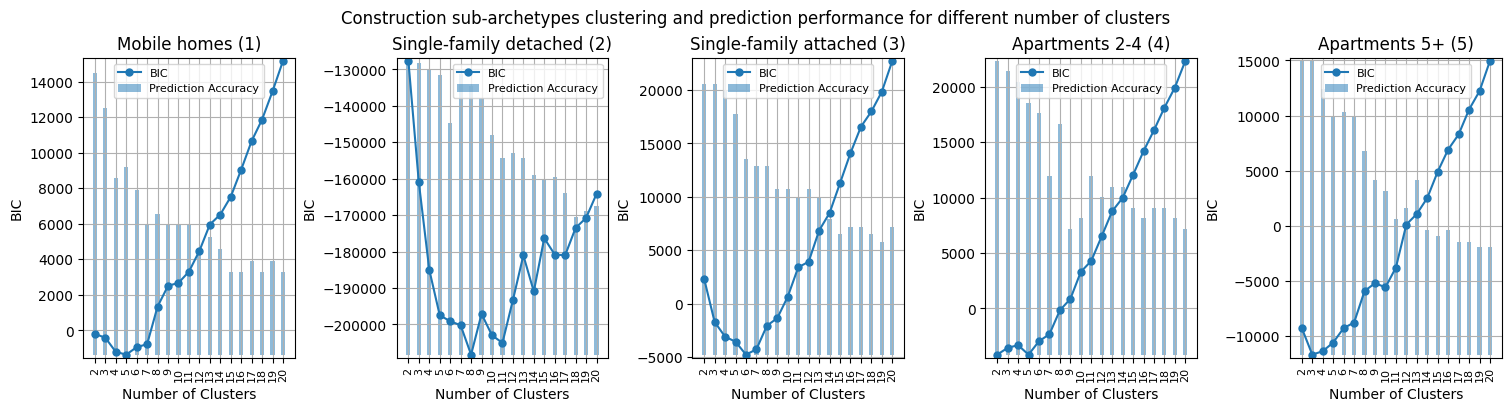

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), layout='constrained')
names = ['Mobile homes (1)', 'Single-family detached (2)', 'Single-family attached (3)', 'Apartments 2-4 (4)',
'Apartments 5+ (5)']
das = []
metrics = []
is_construction = False
for i in [1, 2, 3, 4, 5]:
    subset_criteria = {'IECC_climate_code': '6A', 'TYPEHUQ': i}
    print(i)
    
    if i == 5 & is_construction:
        d, m = cluster_subset_new(categorical_columns, continuous_columns, subset_criteria, evaluate_kmeans, fig, axes, axpos=i - 1, BIC=False);
    else:
        d, m =cluster_subset_new(categorical_columns, continuous_columns, subset_criteria, evaluate_gmm, fig, axes, axpos=i - 1, BIC=True);
    axes[i - 1].set_title(names[i - 1])
    das.append(d)
    metrics.append(m)
fig.suptitle('Construction sub-archetypes clustering and prediction performance for different number of clusters', fontsize=12);
#fig.savefig('print/construction_cluster_performance.png')

In [23]:
[ evaluate_mls(m, 0, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics[0]]

KeyError: 0

## Saving to joblib

In [48]:
sub_archetype_category = 'Systems'
group_no = [1, 2, 3, 4, 5]
cluster_counts = [2, 8, 3, 5, 3] # Sys [2, 8, 3, 5, 3] Cons [2, 7, 2, 3, 3]
predictor_names = [
    'Random Forest',
    'Support Vector Machine',
    'Logistic Regression',
    'Logistic Regression',
    'Gradient Boosting',
] # cons

predictor_names = [
    'Random Forest',
    'Logistic Regression',
    'Logistic Regression',
    'Support Vector Machine',
    'Gradient Boosting',
] # sys

for gn, cc, pn in zip(group_no, cluster_counts, predictor_names):
    dump(
        metrics[gn - 1][cc - 2].pipelines[pn],
        f'models/{sub_archetype_category}_{gn}.joblib'
    )

Attributes to cluster:
['EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT', 'GEOHP', 'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'EQUIPAGE', 'ACEQUIPAGE', 'eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph', 'eui_kwh_elec_col', 'eui_kwh_elec_latent']


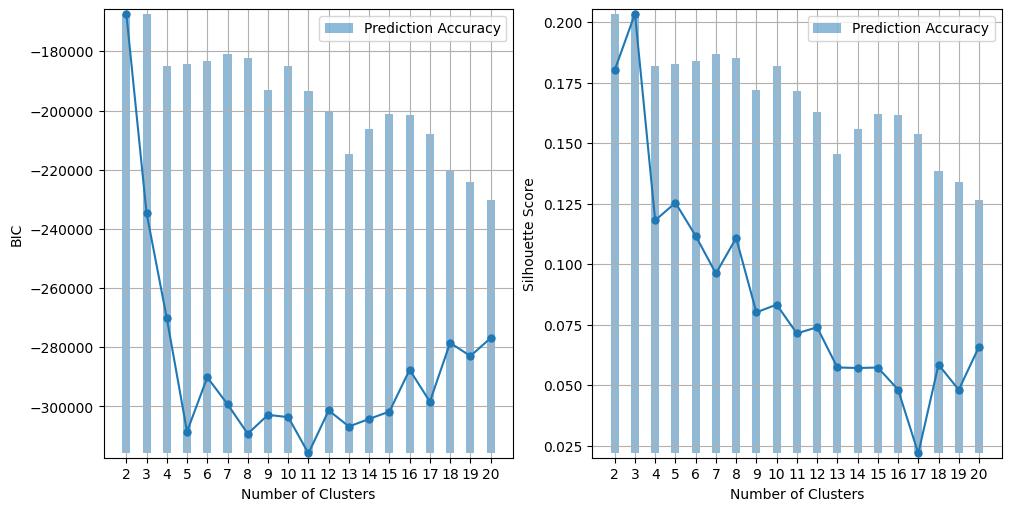

In [24]:
#attributes_to_cluster = ccat_active_loads + ccon_active_loads
subset_criteria = {'IECC_climate_code': '6A'} #'TYPEHUQ': 3
da, metrics = cluster_subset(
    categorical_columns, continuous_columns, subset_criteria, evaluate_gmm)
print('Attributes to cluster:')
print(categorical_columns + continuous_columns)

In [105]:
sub_archetype_category = 'SpaceLoads'
dump(
    metrics[3 - 2].pipelines['Logistic Regression'],
    f'models/{sub_archetype_category}_all.joblib'
)

['models/SpaceLoads_all.joblib']

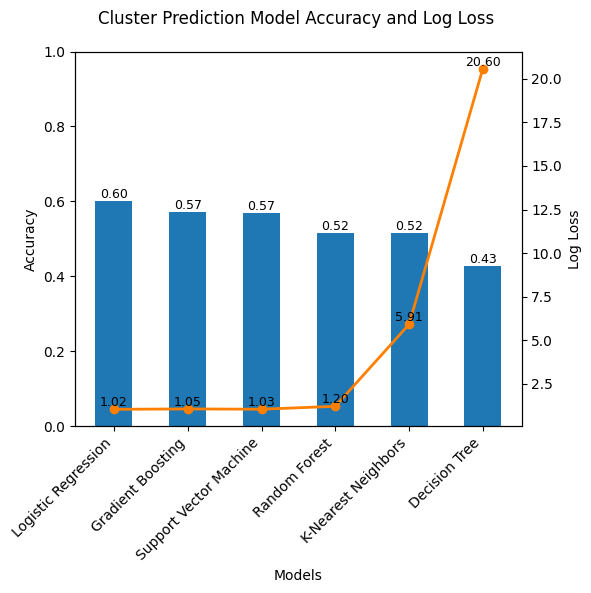

(                    Model  Accuracy   Log Loss
 0     Logistic Regression  0.601610   1.024743
 1       Gradient Boosting  0.571429   1.047172
 2  Support Vector Machine  0.569416   1.029899
 3           Random Forest  0.515091   1.196574
 4     K-Nearest Neighbors  0.515091   5.906537
 5           Decision Tree  0.428571  20.596373,
 0       Logistic Regression
 1         Gradient Boosting
 2    Support Vector Machine
 3             Random Forest
 4       K-Nearest Neighbors
 5             Decision Tree
 Name: Model, dtype: object)

In [39]:
N = 4
N = N - 2 
evaluate_mls(metrics[N], da.index)

In [344]:
all_labels = np.unique(metrics[N].labels)
da_temp = da.copy()
da_temp['label'] = metrics[N].labels


# Group the dataframe by the "label" column
grouped = da_temp.groupby("label")

# Calculate statistics for each cluster
cluster_stats = grouped.apply(lambda group: pd.Series({
    "Most Frequent Categorical Values": group[categorical_columns].mode().iloc[0].to_dict(),
    "Mean of Continuous Values": group[continuous_columns].mean().to_dict()
}))

# Convert results to a more readable format (optional)
formatted_cluster_stats = cluster_stats.to_dict()
charized = pd.concat([
    pd.DataFrame(formatted_cluster_stats['Most Frequent Categorical Values']).T,
    pd.DataFrame(formatted_cluster_stats['Mean of Continuous Values']).T
], axis=1)
for c in charized.columns:
    if c in categorical_columns:
        lgd = get_legend(c).set_index('code')
        charized[c] = charized[c].astype(int)
        charized[c] = charized[c].apply(lambda x: lgd.loc[str(x)])
charized_reg = regular_display_df(
    charized
)
charized_reg
#charized_reg.T.to_csv('output/energyloads.csv')

,CELLAR,CRAWL,CONCRETE,BASEOTH,BASEFIN,ATTIC,ATTICFIN,WALLTYPE,ROOFTYPE,ADQINSUL,TYPEGLASS,WINFRAME,eui_kwh_elec_thermal,eui_btu_ng_thermal,eui_btu_ofuel_thermal,window_per_sqm,door_per_sqm
0,Yes,No,No,No,No,Yes,No,"Siding (aluminum, fiber cement, vinyl, or steel)",Shingles (composition or asphalt),Adequately insulated,Double-pane glass,Wood,17.140,0.e+00,538.887,0.103,5.031e-03
1,Yes,No,No,No,Yes,Yes,No,"Siding (aluminum, fiber cement, vinyl, or steel)",Shingles (composition or asphalt),Adequately insulated,Double-pane glass,Wood,11.702,493.27,4.060,0.114,2.381e-03
2,Yes,No,No,No,No,Yes,No,Wood,Shingles (composition or asphalt),Adequately insulated,Double-pane glass,Wood,7.425,38.555,910.399,0.151,1.459e-03
3,Yes,No,No,No,Yes,Yes,No,"Siding (aluminum, fiber cement, vinyl, or steel)",Shingles (composition or asphalt),Adequately insulated,Double-pane glass,Wood,13.565,378.122,13.804,0.089,4.754e-03
4,Yes,No,No,No,No,Yes,No,"Siding (aluminum, fiber cement, vinyl, or steel)",Metal,Adequately insulated,Double-pane glass,Wood,31.496,306.163,76.789,0.104,4.419e-03
5,Yes,No,No,No,No,Yes,No,Shingle (composition),Shingles (composition or asphalt),Adequately insulated,Single-pane glass,Wood,14.849,699.074,5.065,0.127,2.303e-03
6,Yes,No,No,No,No,Yes,No,"Siding (aluminum, fiber cement, vinyl, or steel)",Shingles (composition or asphalt),Well insulated,Double-pane glass,Composite,10.887,1.92,445.379,0.094,5.868e-03


<Figure size 500x500 with 0 Axes>

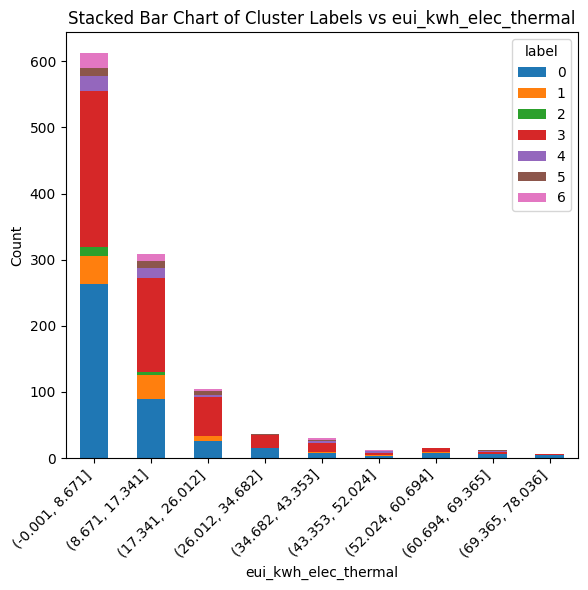

<Figure size 500x500 with 0 Axes>

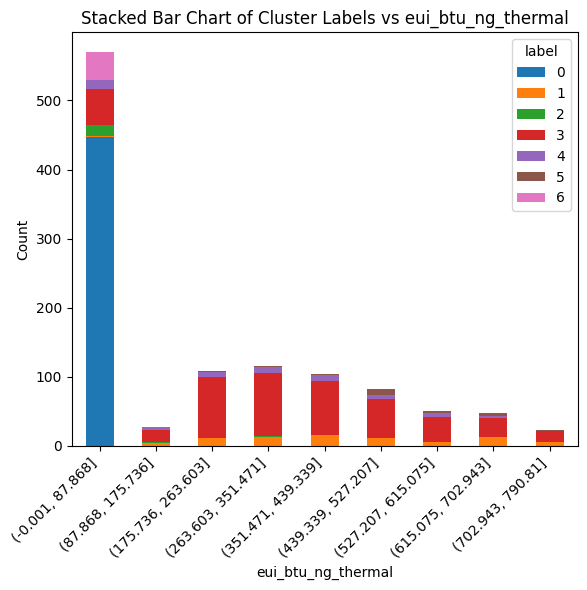

<Figure size 500x500 with 0 Axes>

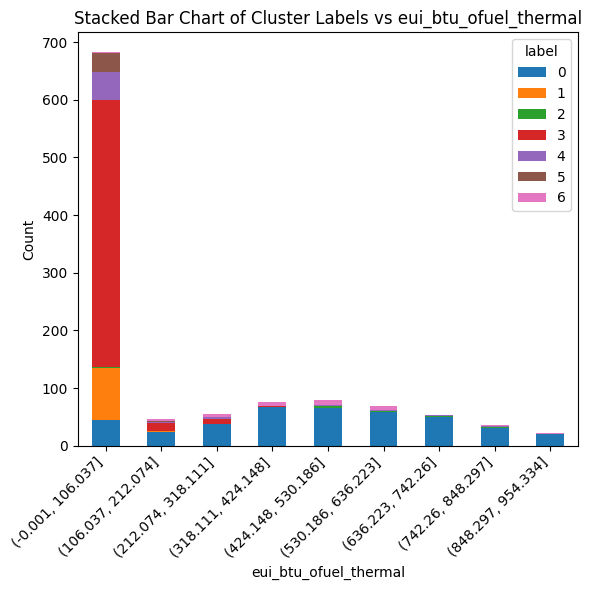

<Figure size 500x500 with 0 Axes>

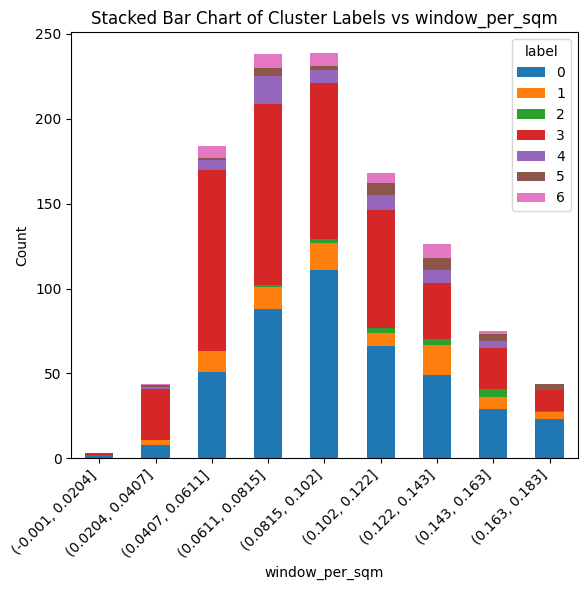

<Figure size 500x500 with 0 Axes>

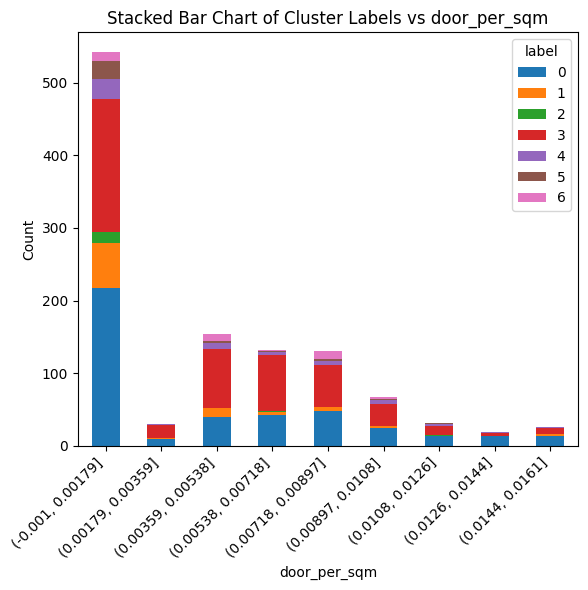

<Figure size 500x500 with 0 Axes>

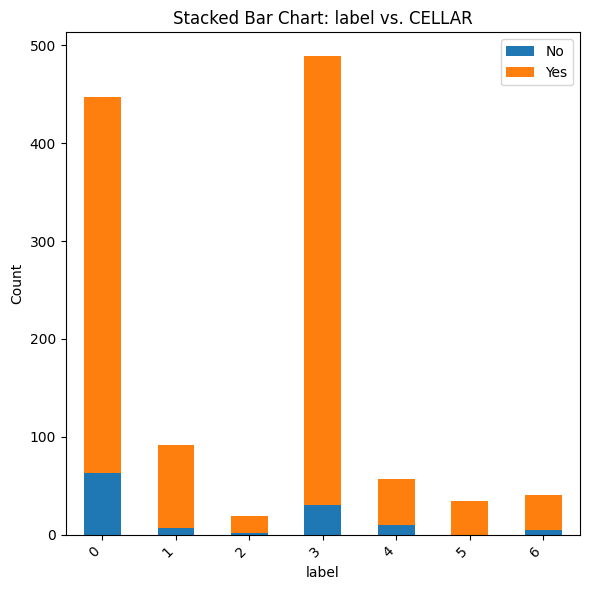

<Figure size 500x500 with 0 Axes>

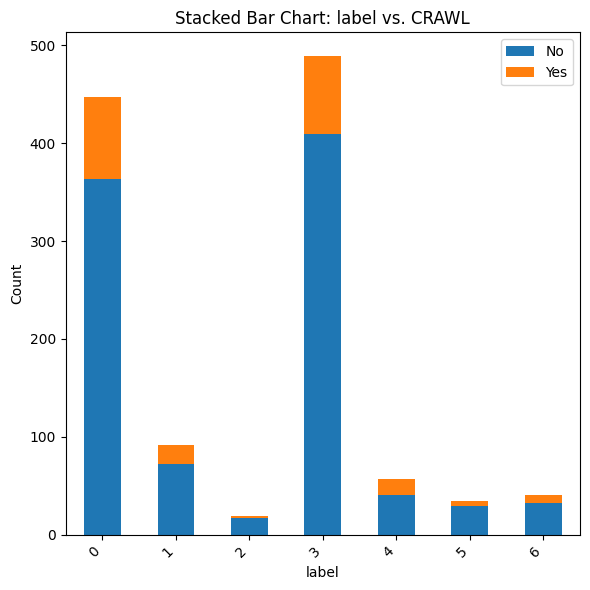

<Figure size 500x500 with 0 Axes>

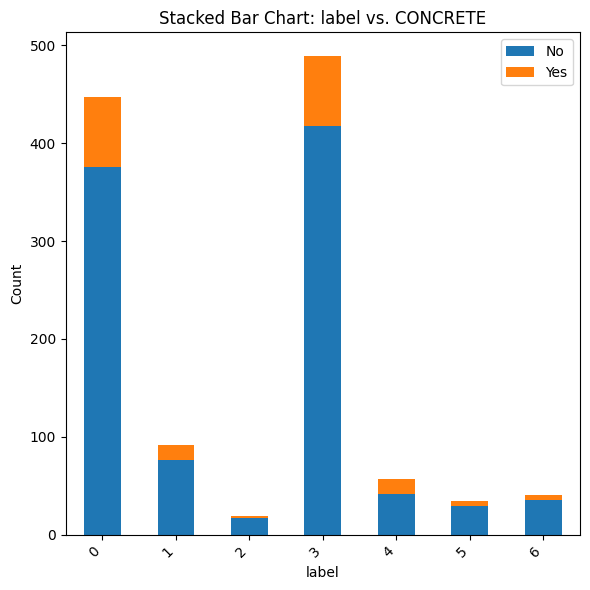

<Figure size 500x500 with 0 Axes>

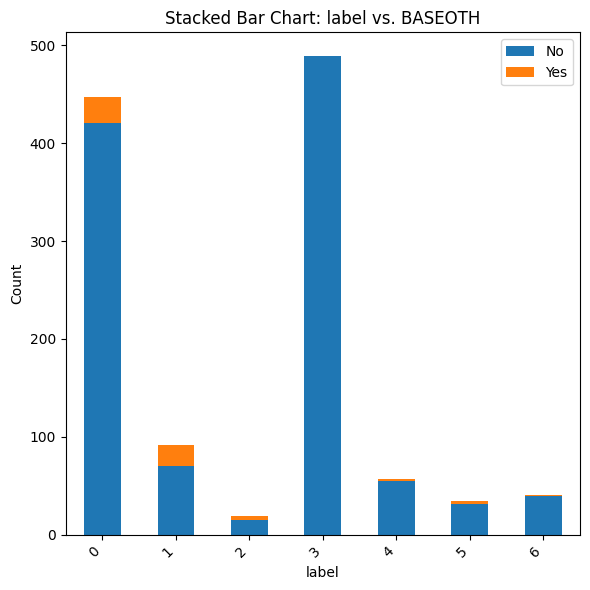

<Figure size 500x500 with 0 Axes>

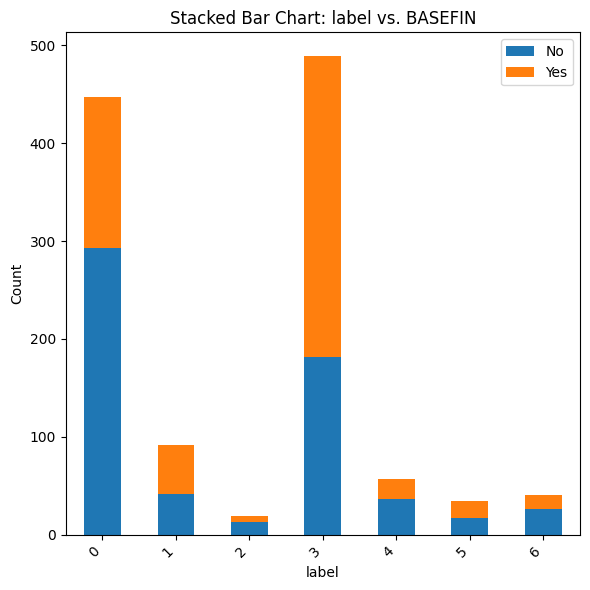

<Figure size 500x500 with 0 Axes>

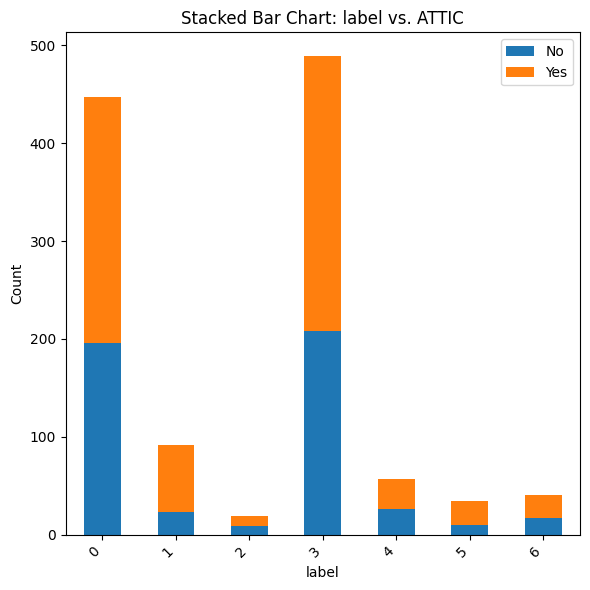

<Figure size 500x500 with 0 Axes>

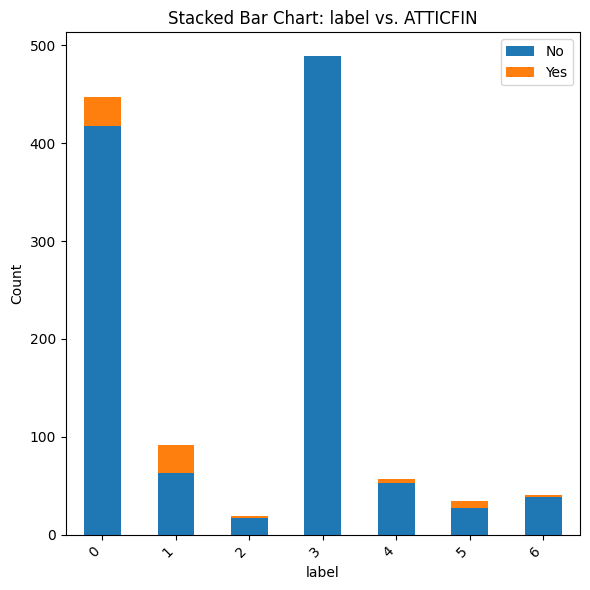

<Figure size 500x500 with 0 Axes>

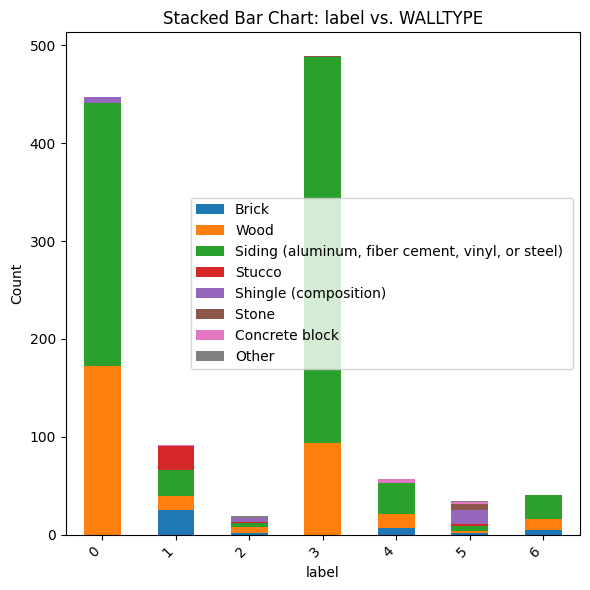

<Figure size 500x500 with 0 Axes>

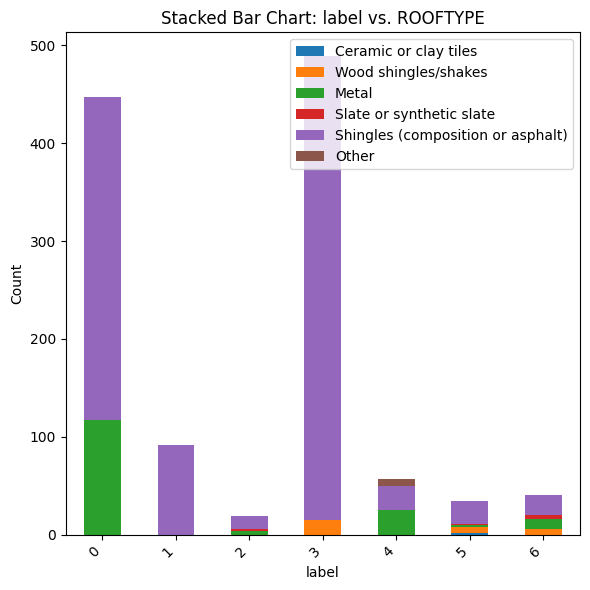

<Figure size 500x500 with 0 Axes>

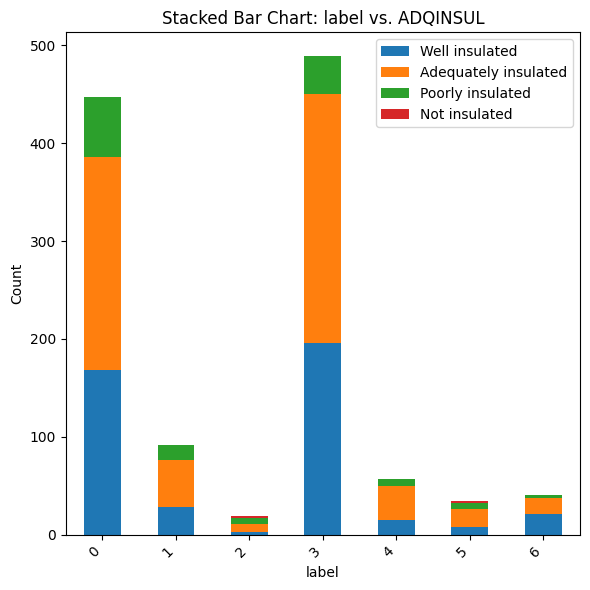

<Figure size 500x500 with 0 Axes>

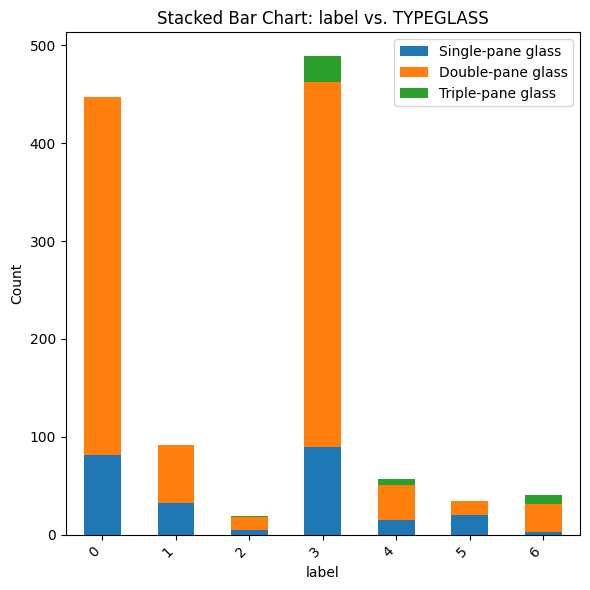

<Figure size 500x500 with 0 Axes>

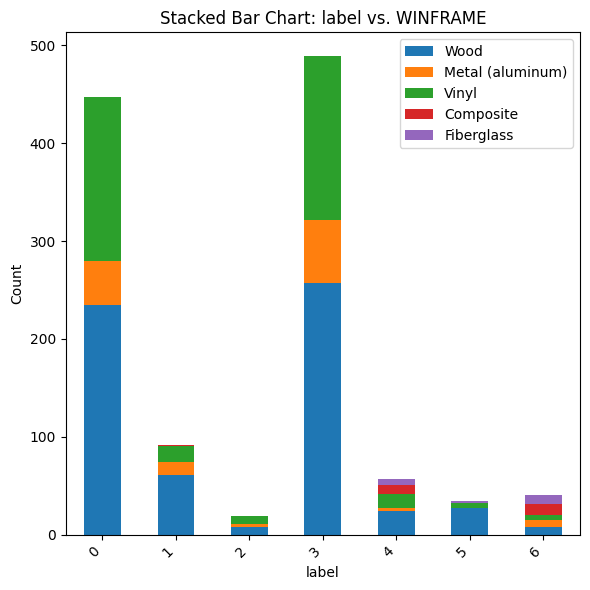

In [346]:
plot_cluster_result_bars(da, metrics[N], ccon=continuous_columns, ccat=categorical_columns)

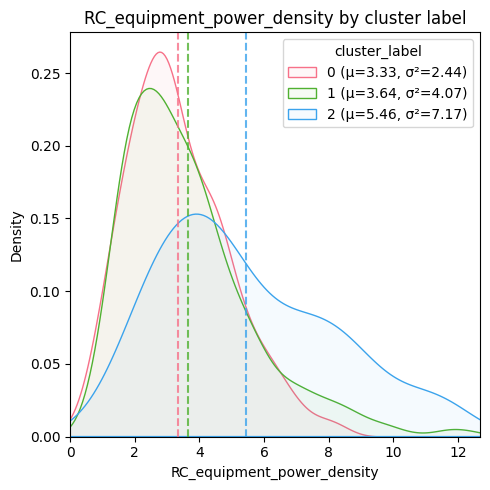

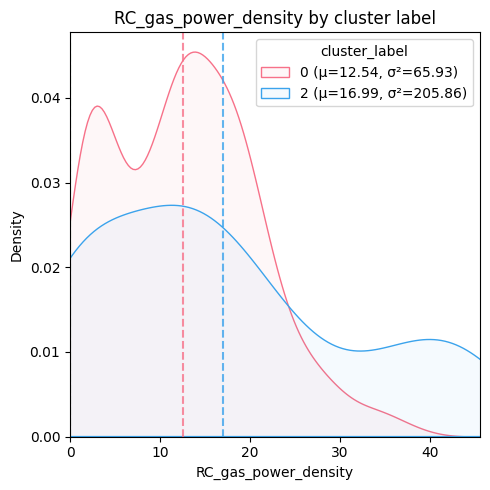

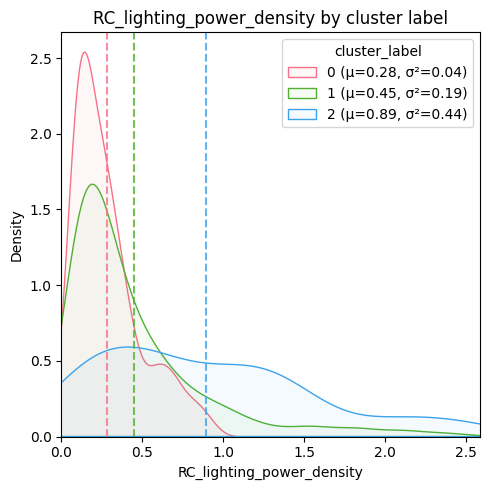

In [362]:
fig, _ = continuous_feature_kde(da, 'RC_equipment_power_density', metrics[N], 0.99)
fig.savefig('print/epd.png')
fig, _ = continuous_feature_kde(da, 'RC_gas_power_density', metrics[N], 0.99)
fig.savefig('print/gpd.png')QD
fig, _ = continuous_feature_kde(da, 'RC_lighting_power_density', metrics[N], 0.99)
fig.savefig('print/lpd.png')

In [48]:
dac = da.copy()
dac['label'] = metrics[N].labels
tpl = compute_cluster_statistics(dac, 'label', categorical_columns, continuous_columns,).sort_values('Cluster')

In [112]:
tpl

,Cluster,RC_equipment_power_density,RC_gas_power_density,RC_lighting_power_density
0,0,3.330728,12.540426,0.282074
2,1,3.728586,0.000000,0.448256
1,2,6.198612,26.633968,1.287061


In [52]:
for c in categorical_columns:
    print(c)
    tpl[c] = tpl[c].apply(lambda x: get_legend(c).set_index('code').loc[str(x)])
tpl

,Cluster,RC_equipment_power_density,RC_gas_power_density,RC_lighting_power_density
0,0,3.330728,12.540426,0.282074
2,1,3.728586,0.000000,0.448256
1,2,6.198612,26.633968,1.287061


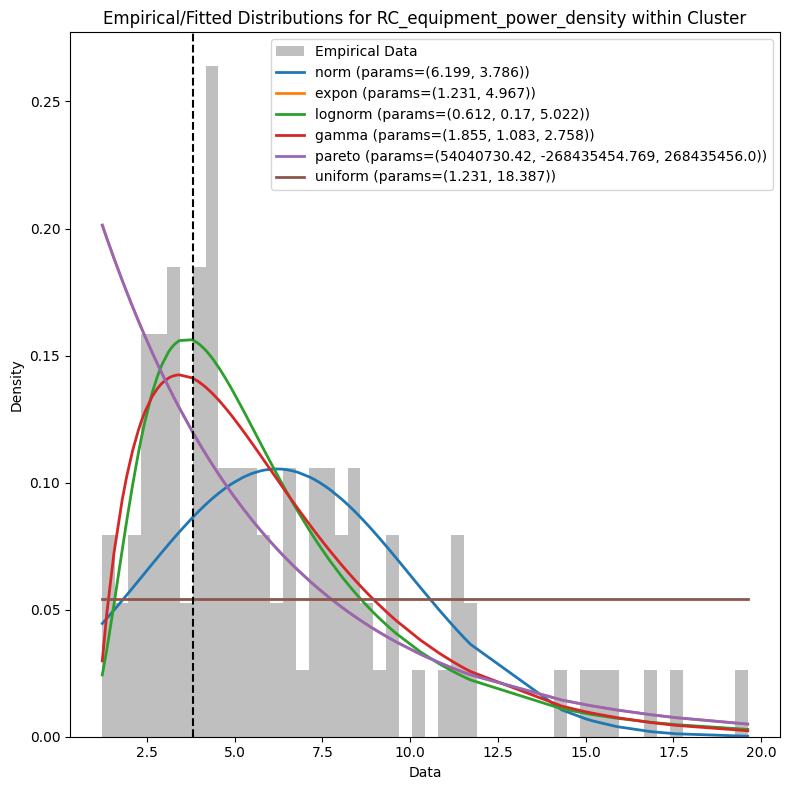

In [384]:
import pandas as pd
import numpy as np
from scipy.stats import norm, expon, kstest, anderson, entropy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, anderson, entropy
from scipy.stats import norm, expon  # Add more distributions as needed

def evaluate_distribution_fit(series: pd.Series, distributions=['norm', 'expon', 'lognorm', 'gamma', 'pareto', 'uniform'], bins=50, plot=True, title_extra=''):
    """
    Evaluates how well an empirical distribution (data column) fits reference distributions
    and plots the empirical and fitted distributions.

    Parameters:
        series (pd.Series): The data column to test.
        distributions (list): List of distribution names to test against (default: ['norm', 'expon']).
        bins (int): Number of bins for histogram-based metrics (default: 50).
        plot (bool): Whether to plot the empirical and fitted distributions (default: True).

    Returns:
        pd.DataFrame: A DataFrame with fit statistics and parameters for each distribution.
    """
    results = []

    # Remove NaN values
    data = series.dropna()
    
    # Sort data for plotting PDFs
    sorted_data = np.sort(data)
    
    # Create a figure for plotting if enabled
    if plot:
        plt.figure(figsize=(8, 8))
        plt.hist(data, bins=bins, density=True, alpha=0.5, label="Empirical Data", color="gray")

    # Loop over each distribution
    for dist_name in distributions:
        # Get the distribution object
        dist = getattr(__import__('scipy.stats', fromlist=[dist_name]), dist_name)
        
        # Fit the distribution to the data
        params = dist.fit(data)
        
        # Generate the PDF for the fitted distribution
        ref_pdf = dist.pdf(sorted_data, *params)
        
        # Add the fitted distribution to the plot
        if plot:
            params_truncated = tuple(round(float(p), 3) for p in params) 
            plt.plot(sorted_data, ref_pdf, label=f'{dist_name} (params={params_truncated})', linewidth=2)

        # Calculate histogram-based empirical density
        emp_hist, edges = np.histogram(data, bins=bins, density=True)
        emp_pdf = emp_hist / emp_hist.sum()
        bin_centers = (edges[:-1] + edges[1:]) / 2
        
        # Interpolate the reference PDF to align with bin centers
        ref_pdf_hist = np.interp(bin_centers, sorted_data, ref_pdf)
        
        # Goodness-of-fit metrics
        ks_stat, ks_p_value = kstest(data, dist_name, args=params)
        # Handle unsupported distributions for Anderson-Darling
        if dist_name in {'norm', 'expon', 'logistic', 'gumbel_l', 'gumbel_r', 'weibull_min'}:
            ad_stat = anderson(data, dist=dist_name).statistic
        else:
            ad_stat = np.nan  # Unsupported distribution
        kl_div = entropy(emp_pdf, ref_pdf_hist + 1e-8)  # Avoid division by zero
        mse = np.mean((emp_pdf - ref_pdf_hist) ** 2)
        log_likelihood = np.sum(dist.logpdf(data, *params))
        
        # Append results
        results.append({
            'Distribution': dist_name,
            'Parameters': params,
            'KS Statistic': ks_stat,
            'KS P-value': ks_p_value,
            #'Anderson-Darling Statistic': ad_stat,
            'KL Divergence': kl_div,
            'MSE': mse,
            'Log-Likelihood': log_likelihood
        })
    
    # Finalize the plot
    if plot:
        plt.title("Empirical/Fitted Distributions for {} within Cluster".format(series.name) + title_extra)
        plt.xlabel("Data")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        #plt.show()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

evaluate_distribution_fit(da['RC_equipment_power_density'].loc[metrics[N].labels==2])
plt.axvline(x=3.82, color='black', linestyle='--', label="Mean")

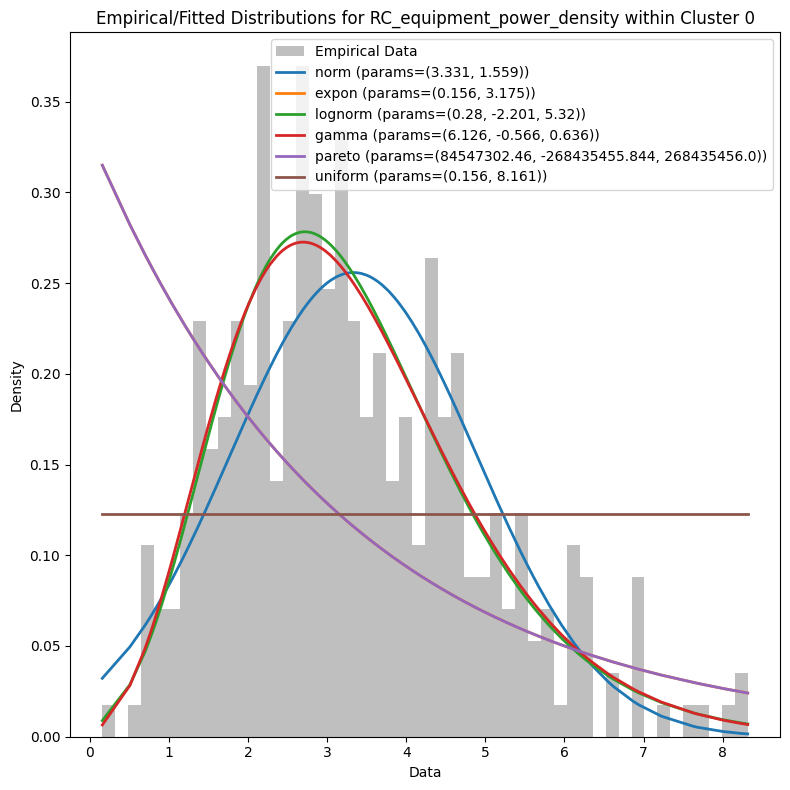

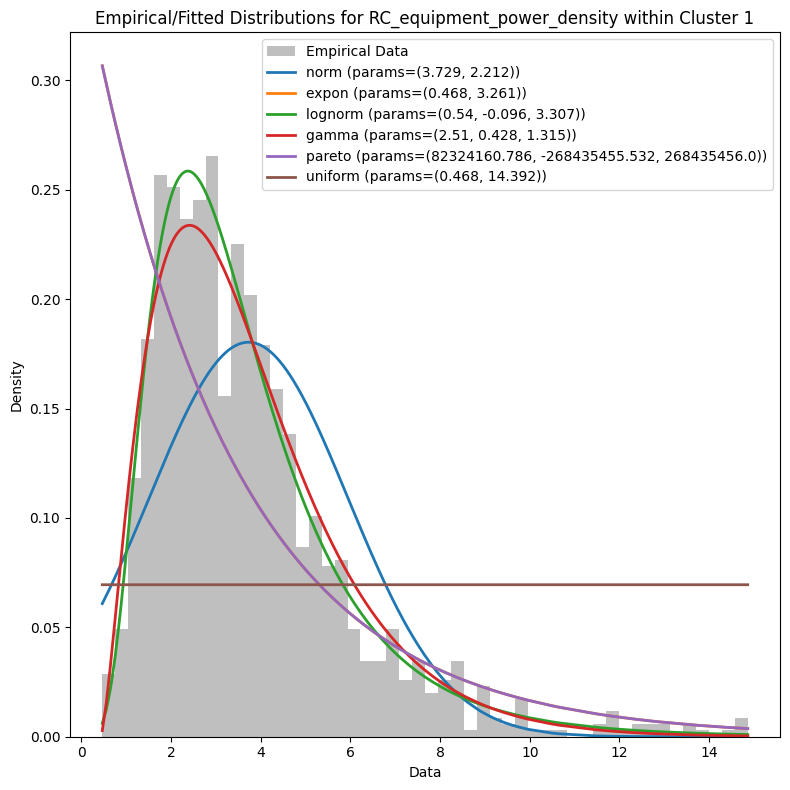

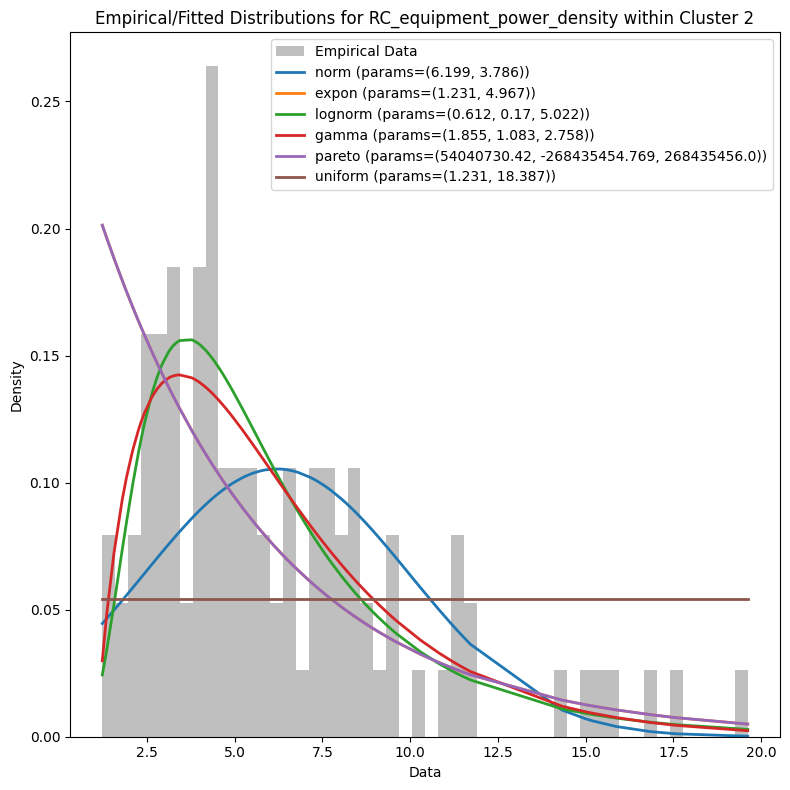

In [386]:
edf = evaluate_distribution_fit(da['RC_equipment_power_density'].loc[metrics[N].labels==0], title_extra=' 0')
plt.gcf().savefig('print/epd1_fit.png')
edf = evaluate_distribution_fit(da['RC_equipment_power_density'].loc[metrics[N].labels==1], title_extra=' 1')
plt.gcf().savefig('print/epd2_fit.png')
edf = evaluate_distribution_fit(da['RC_equipment_power_density'].loc[metrics[N].labels==2], title_extra=' 2')
plt.gcf().savefig('print/epd3_fit.png')

In [146]:

regular_display_df(edf)

,Distribution,Parameters,KS Statistic,KS P-value,KL Divergence,MSE,Log-Likelihood
0,norm,"[26.634, 27.945]",0.174,3.301e-03,0.566,1.278e-03,-4.892e+02
1,expon,"[0.e+00, 26.634]",0.122,0.086,0.303,1.013e-03,-4.411e+02
2,lognorm,"[239.776, -5.e-324, 2.831e-37]",0.517,3.803e-26,0.429,1.642e-03,7.957e+03
3,gamma,"[0.445, -6.846e-28, 34.687]",0.317,1.097e-09,0.372,8.577e-04,-4.344e+01
4,pareto,"[2.016e+07, -5.369e+08, 5.369e+08]",0.122,0.086,0.303,1.013e-03,-4.411e+02
5,uniform,"[0.e+00, 150.787]",0.538,1.831e-28,1.035,1.432e-03,-5.166e+02


In [114]:
regular_display_df(tpl)

,Cluster,RC_equipment_power_density,RC_gas_power_density,RC_lighting_power_density
0,0.e+00,3.331,12.54,0.282
2,1,3.729,0.e+00,0.448
1,2,6.199,26.634,1.287
